In [61]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

In [2]:
df = pd.read_csv('flights.jan.csv')

In [3]:
print('Dimensões do dataframe: ', df.shape)

Dimensões do dataframe:  (469968, 32)


# Limpeza

In [15]:
# informações de valores nulos e tipos das colunas

tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'tipo de dado'})

tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'valores nulos (contagem)'}))

tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'valores nulos (%)'}))
tab_info

/var/folders/m6/535gs6dj4pl874nwyz4wq4340000gn/T/ipykernel_7065/3741533118.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'valores nulos (contagem)'}))
/var/folders/m6/535gs6dj4pl874nwyz4wq4340000gn/T/ipykernel_7065/3741533118.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'valores nulos (%)'}))


,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
tipo de dado,int64,int64,int64,int64,int64,object,int64,object,object,object,...,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
valores nulos (contagem),0,0,0,0,0,0,0,2782,0,0,...,12271,12955,0,0,457986,374017,374017,374017,374017,374017
valores nulos (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591955,0.0,0.0,...,2.611029,2.756571,0.0,0.0,97.450465,79.583504,79.583504,79.583504,79.583504,79.583504


In [16]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [19]:
# Função que converte a string 'HHMM' em datetime.time

def formatar_horario(dado_orig):
  if pd.isnull(dado_orig):
    return np.nan
  else:
    if dado_orig == 2400: dado_orig = 0
    dado_orig = "{0:04d}".format(int(dado_orig))
    horario = datetime.time(int(dado_orig[0:2]), int(dado_orig[2:4]))
    return horario


# Função que combina a data e o horario para criar um datetime.datetime

def combinar_data_horario(x):
  if pd.isnull(x[0]) or pd.isnull(x[1]):
    return np.nan
  else:
    return datetime.datetime.combine(x[0],x[1])


# Função que combina duas colunas do dataframe para criar um formato datetime

def criar_horario_voo(df, col):    
  lista = []
  for index, cols in df[['DATE', col]].iterrows():    
    if pd.isnull(cols[1]):
      lista.append(np.nan)
    elif float(cols[1]) == 2400:
      cols[0] += datetime.timedelta(days=1)
      cols[1] = datetime.time(0,0)
      lista.append(combinar_data_horario(cols))
    else:
      cols[1] = formatar_horario(cols[1])
      lista.append(combinar_data_horario(cols))
  return pd.Series(lista)

In [20]:
df['SCHEDULED_DEPARTURE'] = criar_horario_voo(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(formatar_horario)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(formatar_horario)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(formatar_horario)

In [21]:
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME', 'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


In [25]:
a_remover = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME', 'Unnamed: 0']

df.drop(a_remover, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'SCHEDULED_TIME', 'ELAPSED_TIME']]

df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


In [33]:
valores_faltantes_df = df.isnull().sum(axis=0).reset_index()
valores_faltantes_df.columns = ['Variável', 'Valores faltantes']
valores_faltantes_df['Valores presentes (%)'] = (df.shape[0]-valores_faltantes_df['Valores faltantes'])/df.shape[0]*100
valores_faltantes_df.sort_values('Valores presentes (%)').reset_index(drop = True)

,Variável,Valores faltantes,Valores presentes (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


In [34]:
df.dropna(inplace = True)

In [36]:
df.isnull().sum()

AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
SCHEDULED_TIME         0
ELAPSED_TIME           0
dtype: int64

# Comparando companhias aéreas

In [38]:
companhias_aereas = pd.read_csv('airlines.csv')
companhias_aereas

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [39]:
abrev_companhias = companhias_aereas.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [44]:
# Função que extrai parâmetros estatísticos a partir de um objeto groupby:

def get_stats(group):
  return {'min': group.min(), 'max': group.max(), 'contagem': group.count(), 'média': group.mean()}

In [46]:
# Criação de um dataframe com informações estatísticas de cada companhia:

estats_companhias = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
estats_companhias = estats_companhias.sort_values('contagem')
estats_companhias

,min,max,contagem,média
AIRLINE,,,,
VX,-20.0,397.0,4647.0,6.896277
HA,-26.0,1003.0,6408.0,1.311954
F9,-32.0,696.0,6735.0,17.910765
NK,-28.0,557.0,8632.0,13.073100
AS,-47.0,444.0,13151.0,3.072086
B6,-27.0,500.0,20482.0,9.988331
MQ,-29.0,780.0,27568.0,15.995865
US,-26.0,638.0,32478.0,5.175011
UA,-40.0,886.0,37363.0,13.885555


## Gráficos

In [67]:
fonte = {'family' : 'verdana', 'weight' : 'bold', 'size' : 15}
mpl.rc('font', **fonte)
import matplotlib.patches as mpatches

In [58]:
# Extrair um subset de colunas e redefinir os nomes das companhias aéreas

df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abrev_companhias)

In [73]:
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue', 'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']

Text(0.5, 1.0, '% de vôos por companhia')

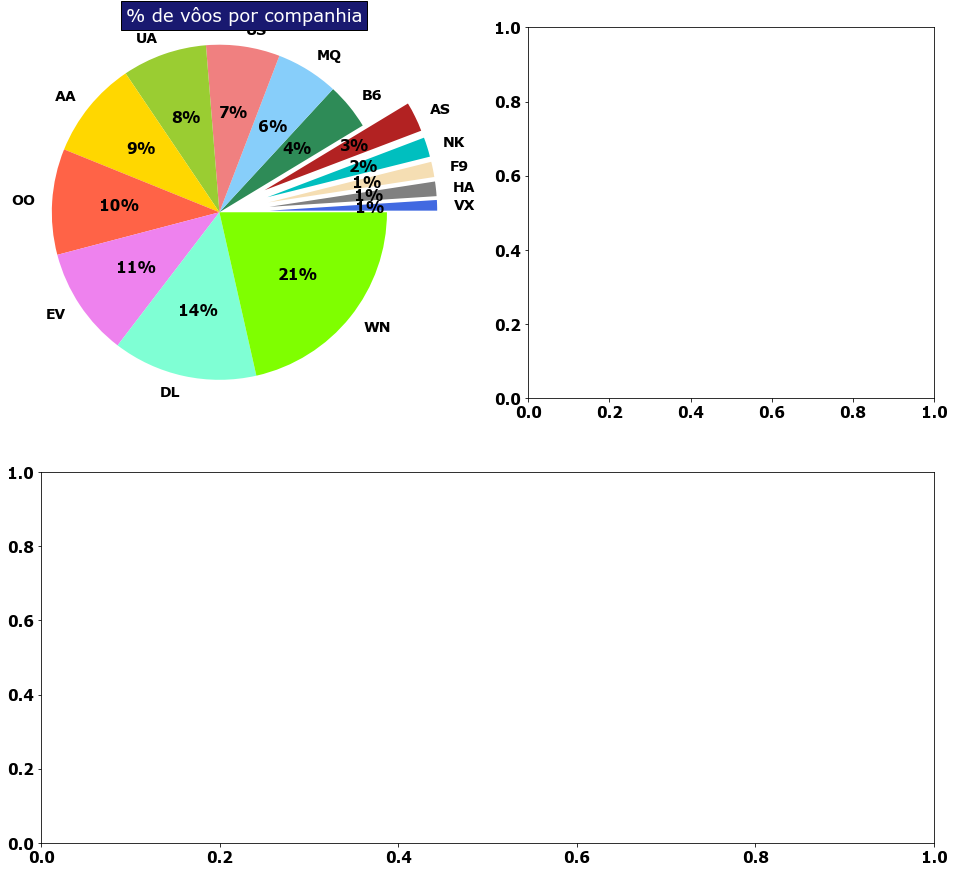

In [91]:
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:])

# Gráfico de pizza 1: número de vôos

labels = [s for s in estats_companhias.index]
sizes = estats_companhias['contagem'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len
          (abrev_companhias))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode, 
                            labels=labels, colors = colors, 
                            autopct='%1.0f%%', shadow=False, 
                            startangle=0)

for i in range(len(abrev_companhias)):
  texts[i].set_fontsize(14)

ax1.axis('equal')
ax1.set_title('% de vôos por companhia', 
              bbox={'facecolor': 'midnightblue', 'pad': 5}, 
              color = 'w', fontsize = 18)

